# Классификация в SKTime

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    import sktime
except:
    !pip install sktime --user
    !pip install tsfresh 
    !pip install numba
    !pip install llvmlite
finally:
    import sktime

In [3]:
from sktime.classification.kernel_based import RocketClassifier

In [4]:
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=NotImplementedError)
warnings.simplefilter('ignore', category=UserWarning)

## Импорт данных

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [17]:
path_ts1 = 'DailyDelhiClimateTrain.csv'
path_ts2 = 'DailyDelhiClimateTest.csv'
df1 = pd.read_csv(path_ts1, parse_dates=['date'], index_col="date")
df2 = pd.read_csv(path_ts2, parse_dates=['date'], index_col="date")
df = pd.concat([df1, df2])
df_unique = df[~df.index.duplicated()].copy() 
df = df_unique
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


In [9]:
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
#     df = df.groupby(df.index.hour).mean()
    df = df.rename_axis('Date')
#     df.index = df.index.strftime('%Y-%m-%d-%h')
    return df

In [21]:
cols_map = {'meantemp':'Mean Temp', 'humidity':'Humidity',
            'wind_speed':'Wind Speed',
            'meanpressure':'Mean Pressure'}
df = transform_dataframe(df, cols_map).dropna()
df.index = df.index.strftime('%Y-%m-%d-%H')
df.to_csv('de_clf_data.csv')

df.head()

,Mean Temp,Humidity,Wind Speed,Mean Pressure
Date,,,,
2013-01-01-00,0.010000,0.084500,0.000000,1.015667
2013-01-02-00,0.007400,0.092000,0.002980,1.017800
2013-01-03-00,0.007167,0.087000,0.004633,1.018667
2013-01-04-00,0.008667,0.071333,0.001233,1.017167
2013-01-05-00,0.006000,0.086833,0.003700,1.016500


In [22]:
df = pd.read_csv('de_clf_data.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index.strftime('%Y-%m-%d-%H'))
df

,Mean Temp,Humidity,Wind Speed,Mean Pressure
Date,,,,
2013-01-01,0.010000,0.084500,0.000000,1.015667
2013-01-02,0.007400,0.092000,0.002980,1.017800
2013-01-03,0.007167,0.087000,0.004633,1.018667
2013-01-04,0.008667,0.071333,0.001233,1.017167
2013-01-05,0.006000,0.086833,0.003700,1.016500
...,...,...,...,...
2017-04-20,0.034500,0.027500,0.005562,0.998625
2017-04-21,0.034250,0.039375,0.006962,0.999875
2017-04-22,0.032900,0.040900,0.008890,1.001600


In [23]:
print(df.index.year)

Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       ...
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
      dtype='int32', name='Date', length=1575)


In [24]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):        
        df_ = pd.concat([df_,df.loc[df.index.month == month]])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [26]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Mean Temp', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Mean Temp', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Mean Temp', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Mean Temp', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(16, 24) (14, 24) (14, 24) (16, 24)


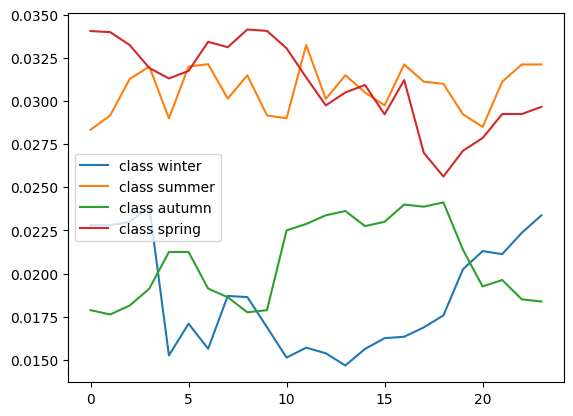

In [27]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

In [28]:
X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(42, 24) (42,) (18, 24) (18,)


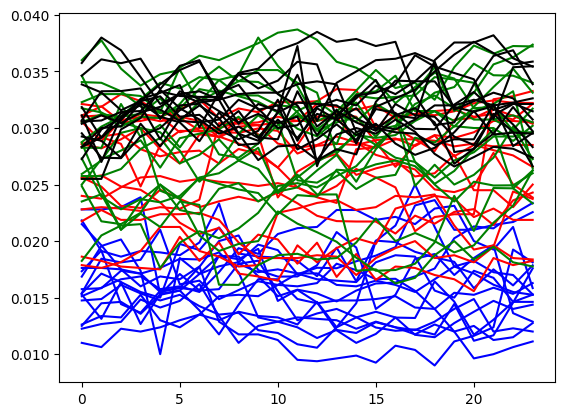

In [29]:
[plt.plot(X[i], c= 'b') for i in range(len(X)) if y[i]==0];
[plt.plot(X[i], c= 'r') for i in range(len(X)) if y[i]==2];
[plt.plot(X[i], c= 'g') for i in range(len(X)) if y[i]==3];
[plt.plot(X[i], c= 'k') for i in range(len(X)) if y[i]==1];


In [30]:
from sktime.datatypes import convert_to
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ") 
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ") 

## Классификация sklearn

In [59]:
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')


 test score 0.556


In [64]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}') 

 test score 0.444


## Классификаторы ВР на основе данных

In [65]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.556


In [68]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.333


In [121]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.167


In [123]:
from sktime.classification.dictionary_based import (ContractableBOSS, 
                                                    IndividualBOSS, 
                                                    IndividualTDE, 
                                                    MUSE, WEASEL)

In [124]:
clf = IndividualBOSS(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.2222222222222222

In [127]:
clf = IndividualTDE(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.2222222222222222

In [130]:
clf = MUSE(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5

## Классификаторы на основе признаков

In [40]:
# from sktime.classification.interval_based import RSTSF
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based._rise import RandomIntervalSpectralEnsemble

In [131]:
clf = TimeSeriesForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.500


In [132]:
clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.500


In [133]:
clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.556


In [134]:
from sklearn.linear_model import LogisticRegressionCV

from sktime.transformations.panel.rocket import MiniRocket


transform = MiniRocket(num_kernels=10000, n_jobs = -1)
Xt_train = transform.fit_transform(X_train)
Xt_test  = transform.transform(X_test)

clf = LogisticRegressionCV()
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.556


In [135]:
from sktime.classification.feature_based import SummaryClassifier, Catch22Classifier
from sklearn.ensemble import RandomForestClassifier

In [136]:
summary_funcs = ("mean", "min", "max", "median", "sum", "skew", "kurt",
    "var", "std", "mad", "sem", "nunique", "count")

clf = SummaryClassifier(summary_functions=summary_funcs,
                        estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.444


In [137]:
clf = Catch22Classifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.500


In [138]:
from sktime.classification.hybrid import HIVECOTEV1, HIVECOTEV2

clf = HIVECOTEV2(time_limit_in_minutes=0.1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.278
